# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

In [1]:
# Mounting Google Drive content
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [2]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image,ImageFile
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from numpy.lib.function_base import trapz
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
def split_train_test(lendata, percentage=0.8):
    idxs_all = np.array(range(lendata))
    np.random.shuffle(idxs_all)
    idx_split = int(lendata * percentage)
    idxs_train, idxs_test = idxs_all[:idx_split], idxs_all[idx_split:]
    return idxs_train, idxs_test

LENDATA = 5000
IMG_PER_LABEL = 1000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)

# Implement the dataset class
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True):
        # path_to_images: where you put the fish dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # transform_extra: extra data transform
        # img_size: resize all images to a standard size
        # train: return training set or test set
        self.path_to_images = path_to_images
        self.idxs_train = idxs_train
        self.idxs_test = idxs_test
        self.img_size = img_size
        self.train = train
        
        # Load all the images and their labels
        self.images = []
        self.labels = []
        
        # Resize all images to a standard size
        img_transforms = [
                      transforms.Resize((img_size, img_size)),
                      transforms.ToTensor(),
                      transforms.Normalize(
                          (0.5, 0.5, 0.5), 
                          (0.5, 0.5, 0.5)
                          )
        ]

        if transform_extra:
          img_transforms.extend(transform_extra)

        self.img_transform = transforms.Compose(img_transforms)

        for label in Multiclass_labels_correspondances:
          label_path = os.path.join(path_to_images, label, "%05d.png") 
          print("Currently importing: ", label)

          for i in range(1,IMG_PER_LABEL + 1):
            image_path = label_path % i
            self.images.append(self.img_transform(Image.open(image_path))) 
            self.labels.append(label)

        # Extract the images and labels with the specified file indexes      
        self.train_x = [self.images[i] for i in self.idxs_train]
        self.train_y = [self.labels[i] for i in self.idxs_train]

        self.test_x = [self.images[i] for i in self.idxs_test]
        self.test_y = [self.labels[i] for i in self.idxs_test]
        
    def __len__(self):
        if self.train:
          return len(self.train_y)
        else:
          return len(self.test_y)
        
    def __getitem__(self, idx):
        # Get an item using its index
        if self.train:
          image, target = self.train_x[idx], self.train_y[idx]
        else:
          image, target = self.test_x[idx], self.test_y[idx]
        
        # Return the image and its label
        return image, target

    # Helper Functions
    def get_num_samples_per_class(self, isTraining=True):
      selected_set = self.train_y if isTraining else self.test_y
      (unique, counts) = np.unique(selected_set, return_counts=True)
      return dict(zip(unique, counts))

    def gen_sample_per_class(self):
      sample_indexes = dict()
      while len(sample_indexes) < len(Multiclass_labels_correspondances):
        random_idx = np.random.randint(len(self.train_y))
        label = self.train_y[random_idx]
        sample_indexes[label] = random_idx
      for label in sample_indexes:
        image_idx = sample_indexes[label]
        sample_indexes[label] = self.train_x[image_idx]
      return sample_indexes

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

In [4]:
# Training set
image_path = '/content/drive/My Drive/Fish_Dataset/'
dataset  = FishDataset(image_path, idxs_train, idxs_test, None, img_size=128, train = True)

Currently importing:  Black Sea Sprat
Currently importing:  Gilt-Head Bream
Currently importing:  Shrimp
Currently importing:  Striped Red Mullet
Currently importing:  Trout


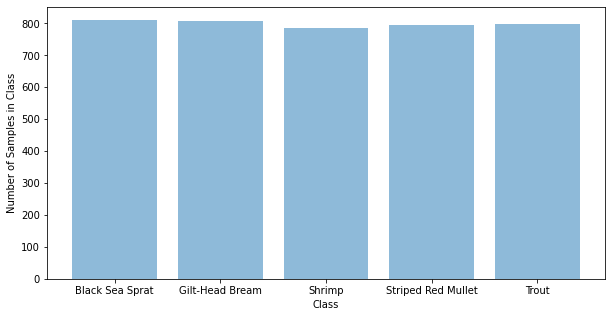

In [5]:
# Plot the number of samples per class
num_samples_per_class = dataset.get_num_samples_per_class()
plt.figure(figsize=(10, 5))
plt.bar(num_samples_per_class.keys(), num_samples_per_class.values(), align = 'center', alpha = 0.5)
plt.ylabel('Number of Samples in Class')
plt.xlabel('Class')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


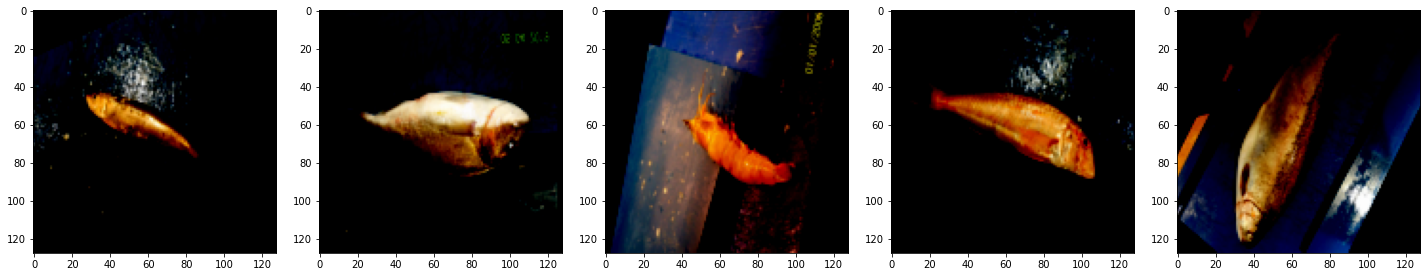

In [6]:
# Plot 1 sample from each of the five classes in the training set
fig = plt.figure(figsize=(20,20))
samples_per_class = dataset.gen_sample_per_class()
for idx, sample in enumerate(samples_per_class.keys()):
  image = samples_per_class[sample]
  image / 2 + 0.5
  image = np.transpose(image, (1,2,0))
  fig.add_subplot(1,5, idx+1)
  plt.imshow(image)
fig.tight_layout()
plt.show()

### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?
 * This selection seems relatively balanced, with approximately 800 samples for each class.

* Can you think of 3 ways to make the dataset balanced if it is not?
  * We can augment the images to create a larger sample size - this includes
    * flipping the images
    * rotating the images
    * changing scales of the images

* Is the dataset already pre-processed? If yes, how?
  * The dataset is pre-processed. The images are all normalised and resized.

#### ADD YOUR RESPONSE HERE ####

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [7]:
class Net(nn.Module):
    def __init__(self, output_dims = 1):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)

        self.fc_1 = nn.Linear(256, 4096)
        self.fc_2 = nn.Linear(4096, 1024)
        self.fc_3 = nn.Linear(1024, output_dims)


    def forward(self, x):
        # Forward propagation
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)

        x = x.view(x.shape[0], -1)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)

        return x

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [8]:
# Network
model = Net(output_dims=len(Multiclass_labels_correspondances.keys())) 
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Number of iterations for training
epochs = 10

# Training batch size
train_batch_size = 64

In [9]:
# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataset = FishDataset(image_path, idxs_train, idxs_test, None, img_size=128, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)

test_dataset = FishDataset(image_path, idxs_train, idxs_test, None, img_size=128, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=train_batch_size, shuffle=False, num_workers=2)

Currently importing:  Black Sea Sprat
Currently importing:  Gilt-Head Bream
Currently importing:  Shrimp
Currently importing:  Striped Red Mullet
Currently importing:  Trout
Currently importing:  Black Sea Sprat
Currently importing:  Gilt-Head Bream
Currently importing:  Shrimp
Currently importing:  Striped Red Mullet
Currently importing:  Trout


### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [10]:
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    
    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        optimizer.zero_grad()
        y_pred = model(imgs)

        num_labs = [Multiclass_labels_correspondances[label] for label in labs] 
        num_labs = torch.from_numpy(np.asarray(num_labs))

        loss = criterion(y_pred, num_labs)

        loss.backward()
        optimizer.step()
        
        loss_curve += [loss.detach().item()]
        
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

 10%|█         | 1/10 [01:13<11:02, 73.57s/it]

--- Iteration 1: training loss = 1.1107 ---


 20%|██        | 2/10 [02:25<09:39, 72.39s/it]

--- Iteration 2: training loss = 0.5605 ---


 30%|███       | 3/10 [03:35<08:20, 71.49s/it]

--- Iteration 3: training loss = 0.3194 ---


 40%|████      | 4/10 [04:48<07:11, 71.91s/it]

--- Iteration 4: training loss = 0.1417 ---


 50%|█████     | 5/10 [05:58<05:56, 71.29s/it]

--- Iteration 5: training loss = 0.1040 ---


 60%|██████    | 6/10 [07:08<04:44, 71.05s/it]

--- Iteration 6: training loss = 0.1032 ---


 70%|███████   | 7/10 [08:18<03:31, 70.63s/it]

--- Iteration 7: training loss = 0.0496 ---


 80%|████████  | 8/10 [09:31<02:22, 71.33s/it]

--- Iteration 8: training loss = 0.0216 ---


 90%|█████████ | 9/10 [10:44<01:11, 71.72s/it]

--- Iteration 9: training loss = 0.0221 ---


100%|██████████| 10/10 [11:56<00:00, 71.63s/it]

--- Iteration 10: training loss = 0.0117 ---


### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [11]:
# Deploy the model
model.eval()
hits = 0
miss = 0
actual_labels = []
predicted_labels = []

with torch.no_grad():
  for test_images, test_label_enums in test_dataloader:
    logits = model(test_images)
    
    predicted_label = torch.max(logits.data,1)[1]
    test_labels = [Multiclass_labels_correspondances[label] for label in test_label_enums]

    for i in range(len(test_labels)):
        if test_labels[i]== predicted_label[i]:
          hits += 1
        else:
          miss += 1

    predicted_labels.extend(list(predicted_label))
    actual_labels.extend(list(test_labels))

print("Hits: ", hits, "Miss: ", miss)


Hits:  997 Miss:  3


### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

Accuracy:  0.997


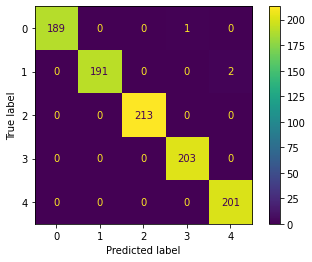

In [12]:
print("Accuracy: ", hits / (hits + miss))
confusion = confusion_matrix(predicted_labels, actual_labels)
display = ConfusionMatrixDisplay(confusion)
display.plot()
plt.show()

## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [13]:
Multiclass_labels_correspondances ={
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

LENDATA = 4000
idxs_train, idxs_test = split_train_test(LENDATA, 0.8)

# Dataloaders
train_dataset = FishDataset(image_path, idxs_train, idxs_test, None, img_size = 128, train = True)
train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = 2)

test_dataset = FishDataset(image_path, idxs_train, idxs_test, None, img_size = 128, train = False)
test_dataloader = DataLoader(test_dataset, batch_size = train_batch_size, shuffle = False, num_workers = 2)

Currently importing:  Hourse Mackerel
Currently importing:  Red Mullet
Currently importing:  Red Sea Bream
Currently importing:  Sea Bass
Currently importing:  Hourse Mackerel
Currently importing:  Red Mullet
Currently importing:  Red Sea Bream
Currently importing:  Sea Bass


### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [14]:
def freeze_till_last_layer(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_till_last_layer(model)
# Modify the last layer. This layer is not freezed.
model.fc_2 = nn.Linear(4096, 1024)
model.fc_3 = nn.Linear(1024, len(Multiclass_labels_correspondances))

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Number of iterations for training
epochs = 10

# Training batch size
train_batch_size = 256

### Step 4.3: Train and test your finetuned model. (5 points)

In [15]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []

    for imgs, labs in train_dataloader:
      optimizer.zero_grad()
      y_pred = model(imgs)

      num_labs = [Multiclass_labels_correspondances[label] for label in labs] 
      num_labs = torch.from_numpy(np.asarray(num_labs))

      loss = criterion(y_pred, num_labs)
      
      loss.backward()
      optimizer.step()

      loss_curve += [loss.detach().item()]

    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))


 10%|█         | 1/10 [00:30<04:38, 30.93s/it]

--- Iteration 1: training loss = 0.6873 ---


 20%|██        | 2/10 [01:01<04:06, 30.86s/it]

--- Iteration 2: training loss = 0.3852 ---


 30%|███       | 3/10 [01:32<03:34, 30.67s/it]

--- Iteration 3: training loss = 0.2647 ---


 40%|████      | 4/10 [02:02<03:04, 30.71s/it]

--- Iteration 4: training loss = 0.1844 ---


 50%|█████     | 5/10 [02:33<02:33, 30.64s/it]

--- Iteration 5: training loss = 0.1317 ---


 60%|██████    | 6/10 [03:04<02:03, 30.76s/it]

--- Iteration 6: training loss = 0.0918 ---


 70%|███████   | 7/10 [03:35<01:32, 30.76s/it]

--- Iteration 7: training loss = 0.0685 ---


 80%|████████  | 8/10 [04:05<01:01, 30.75s/it]

--- Iteration 8: training loss = 0.0707 ---


 90%|█████████ | 9/10 [04:36<00:30, 30.63s/it]

--- Iteration 9: training loss = 0.0434 ---


100%|██████████| 10/10 [05:10<00:00, 31.04s/it]

--- Iteration 10: training loss = 0.0310 ---


In [16]:
# Deploy the model on the test set
model.eval()
hits = 0
miss = 0
actual_labels = []
predicted_labels = []

with torch.no_grad():
  for test_images, test_label_enums in test_dataloader:
    logits = model(test_images)

    predicted_label = torch.max(logits.data,1)[1]
    test_labels = [Multiclass_labels_correspondances[label] for label in test_label_enums]

    for i in range(len(test_labels)):
      if test_labels[i]== predicted_label[i]:
        hits += 1
      else:
        miss += 1

    predicted_labels.extend(list(predicted_label))
    actual_labels.extend(list(test_labels))
    
print("Hits: ", hits, "Miss: ", miss)
print("Accuracy: ", hits / (hits + miss))

Hits:  780 Miss:  20
Accuracy:  0.975


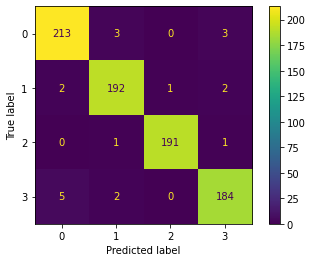

In [17]:
# Evaluate the performance
confusion = confusion_matrix(predicted_labels, actual_labels)
display = ConfusionMatrixDisplay(confusion)
display.plot()
plt.show()

### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

The finetuning seemed to have worked.

Despite the lower accuracy (0.997 v. 0.975), it is still a very high accuracy overall.

The reasoning behind the freezing of the first few layers are due to the large amount of similarities between different species and so we can just split on a fewer range of features. The main differentiation is done in the final layer where smaller attributes are differentiated